In [154]:
import ase
from ase.io import read, write
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import os
import subprocess

## SetUp
In this first section we set all the names for the input and output files necessaryfor the workflow 

In [155]:
# In this first section we  will define all the output files
primitive_cell = "PrimitiveCells/SiO2_Primitive.cif" 
out_supercell = "SuperCells/SiO2_Supercell.xyz" 
out_pre_solvated_gro = "PreSolvated/SiO2_Supercell_vacuum.gro"
out_postsolvated_gro = "Solvated/SiO2_Supercell_solvated.gro"
out_for_lammps = "LAMMPS_INPUT/SiO2_Supercell_solvated.data"
out_for_extxyz = "EXTXYZ_INPUT/SiO2_Supercell_solvated.extxyz"

In [156]:
# Read the CIF file for the primitive cell of SiO2
primitive = read(primitive_cell)

## Building the supercell

In [157]:
# Repeat the primitive cell in order to create the desired supercell and visualize the result
supercell = primitive.repeat((3, 3, 2))
supercell.write(out_supercell, format="extxyz")

# In this section we save the total number of atoms in the supercell, since this information will be used later in the script
old_number_of_atoms = len(supercell)
print(f"Number of atoms in the supercell: {old_number_of_atoms}")

Number of atoms in the supercell: 162


In [158]:
# Modify the box dimensions in order to create the vacuum for water
old_volume = supercell.get_volume()
old_supercell = supercell.get_cell()
supercell.cell[2, 2] += 25.0
new_volume = supercell.get_volume()
print("Old volume: ", old_volume)
print("New volume: ", new_volume)
print(f"The old supercell is equal to: {old_supercell}")
print(f"The new supercell is equal to: {supercell.get_cell()}")
#view(supercell)

Old volume:  2036.360773108868
New volume:  6745.449770012124
The old supercell is equal to: Cell([[14.748000000000001, 0.0, 0.0], [-7.373999999999998, 12.772142655012903, 0.0], [0.0, 0.0, 10.8108]])
The new supercell is equal to: Cell([[14.748000000000001, 0.0, 0.0], [-7.373999999999998, 12.772142655012903, 0.0], [0.0, 0.0, 35.8108]])


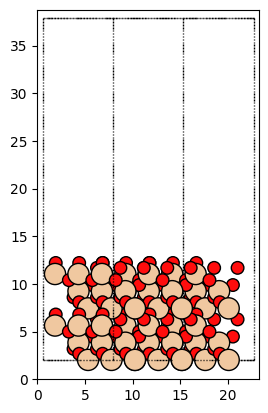

In [159]:
# Visulize the supercell with the vacuum
plot_atoms(supercell, rotation='270x', show_unit_cell=2)
plt.show()

## Gromacs section
In this section we solvate the prepared sample, to get the complete system.

In [160]:
# As a preliminary check we have to: check and remove each file if it exists
for file_path in [out_pre_solvated_gro, out_postsolvated_gro]:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"File not found: {file_path}")


        # We do that since gromacs will not overwrite the foiles and it will create a mess in the folder

Deleted: PreSolvated/SiO2_Supercell_vacuum.gro
Deleted: Solvated/SiO2_Supercell_solvated.gro


In [161]:
# Save the modified supercell with vacuum in a GROMACS format
supercell.write(out_pre_solvated_gro, format="gromacs")
subprocess.run(["gmx", "solvate", "-cp", out_pre_solvated_gro, "-o", out_postsolvated_gro])
solvated = read(out_postsolvated_gro)
print(solvated.get_cell())


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Cell([[14.748000000000001, 0.0, 0.0], [-7.3740000000000006, 12.7721, 0.0], [0.0, 0.0, 35.8108]])


          :-) GROMACS - gmx solvate, 2023.3-Ubuntu_2023.3_1ubuntu3 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /home/forina/Documents/Simulations/SamplePreparation
Command line:
  gmx solvate -cp PreSolvated/SiO2_Supercell_vacuum.gro -o Solvated/SiO2_Supercell_solvated.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generating solvent configuration
Will generate new solvent configuration of 1x1x2 boxes
Solvent box contains 1068 atoms in 356 residues
Removed 432 solvent atoms due to solvent-solvent overlap
Removed 216 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms):   140 residues
Generated solvent containing 420 atoms in 140 residues
Writing generated configuration to Solvated/SiO2_Supercell_solvated.gro

Output configuration contains 582 atoms in 141 residues
Volume                 :     6.74543 (nm^3)
Density                :     1419.61 (g/l)
Num

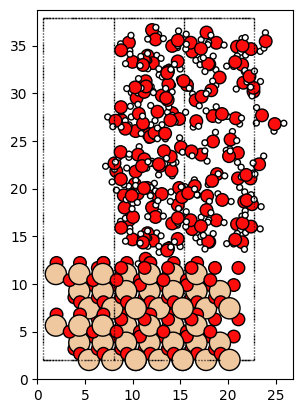

In [162]:
# Visualize the solvated system
plot_atoms(solvated, rotation='270x', show_unit_cell=2)
plt.show()


## Check 
In this last section we simply check the main quantities of interest in order to check that everything has gone fine during the solvation.
If everything is fine, you can definetely save the structure as a LAMMPS input file and start running the simulations.

In [163]:
def compute_water_density(n_molecules, volume_A3):
    """
    Compute the density of water in g/cm^3.

    Parameters:
    - n_molecules (int): Number of H2O molecules
    - volume_A3 (float): Volume in Å^3

    Returns:
    - density (float): Density in g/cm^3
    """
    # Constants
    molar_mass_water = 18.01528  # g/mol
    avogadro_number = 6.022e23   # 1/mol
    mass_per_molecule = molar_mass_water / avogadro_number  # g

    # Total mass in g
    total_mass = n_molecules * mass_per_molecule

    # Convert volume from Å^3 to cm^3 (1 Å^3 = 1e-24 cm^3)
    volume_cm3 = volume_A3 * 1e-24

    # Density = mass / volume
    density = total_mass / volume_cm3
    return density

In [164]:
# Here we will check the number of atoms in the solvated system to ompute the water density.
new_number_of_atoms = len(solvated)
print(f"Number of atoms in the not solvated system: {old_number_of_atoms}")
print(f"Number of atoms in the solvated system: {new_number_of_atoms}")
number_of_water_molecules = (new_number_of_atoms - old_number_of_atoms)/3
density_water = compute_water_density(number_of_water_molecules, new_volume - old_volume)
print(f"Number of water molecules: {number_of_water_molecules}")
print(f"Density of water: {density_water:.3f} g/cm^3")
print(f"The Delta in the Volume is  equal to: {new_volume - old_volume:.3f} Å^3")
print(f"The new volume is equal to:  {new_volume:.3f} Å^3")
print(f"The old volume is equal to:  {old_volume:.3f} Å^3")

Number of atoms in the not solvated system: 162
Number of atoms in the solvated system: 582
Number of water molecules: 140.0
Density of water: 0.889 g/cm^3
The Delta in the Volume is  equal to: 4709.089 Å^3
The new volume is equal to:  6745.450 Å^3
The old volume is equal to:  2036.361 Å^3


In [165]:
# Save the solvated system as a LAMMPS input file
solvated.write(out_for_lammps, format="lammps-data")
solvated.write(out_for_extxyz, format="extxyz")